# Example: Mixed-Element Mesh for Delineated Subwatersheds

This notebook demonstrates how to create stream-aligned meshes for subcatchments and subwatersheds. The triangulation respects subwatershed boundaries, enabling the creation of distinct regions for surface and subsurface domains along with their respective boundaries. This approach facilitates monitoring of subdomain-specific fluxes and states, as well as performing detailed water balance analyses for individual subdomains. 

In [1]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
import geopandas
from matplotlib import pyplot as plt
import logging
pandas.set_option('display.max_columns', None) 

import shapely
import pickle

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.resampling
import watershed_workflow.condition
import watershed_workflow.sources.standard_names as names
watershed_workflow.ui.setup_logging(1,None)

In [3]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating


# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000


log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [4]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [5]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [6]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [7]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2025-08-01 15:51:44,388 - root - INFO: 
2025-08-01 15:51:44,388 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2025-08-01 15:51:44,388 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [8]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.getDefaultSources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDPlus MR v2.1']
sources['HUC'] = watershed_workflow.source_list.huc_sources['WaterData WBD']
watershed_workflow.source_list.logSources(sources)

2025-08-01 15:51:44,411 - root - INFO: Using sources:
2025-08-01 15:51:44,411 - root - INFO: --------------
2025-08-01 15:51:44,412 - root - INFO: HUC: WaterData
2025-08-01 15:51:44,412 - root - INFO: hydrography: WaterData
2025-08-01 15:51:44,412 - root - INFO: DEM: 3DEP
2025-08-01 15:51:44,413 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2025-08-01 15:51:44,413 - root - INFO: geologic structure: GLHYMPS version 2.0
2025-08-01 15:51:44,413 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2021_cover_L48
2025-08-01 15:51:44,413 - root - INFO: LAI: MODIS
2025-08-01 15:51:44,414 - root - INFO: depth to bedrock: Pelletier DTB
2025-08-01 15:51:44,414 - root - INFO: meteorology: DayMet 1km


# Basin Geometry

In this section, we choose the basin, the streams to be included in the stream-aligned mesh, and make sure that all are resolved discretely at appropriate length scales for this work.

## the Watershed

Note the internal boundaries in the domain for subwatersheds.

2025-08-01 15:51:46,550 - root - INFO: Removing holes on 3 polygons
2025-08-01 15:51:46,551 - root - INFO:   -- removed interior
2025-08-01 15:51:46,553 - root - INFO:   -- union
2025-08-01 15:51:46,553 - root - INFO: Parsing 1 components for holes
2025-08-01 15:51:46,553 - root - INFO:   -- complete


<Axes: >

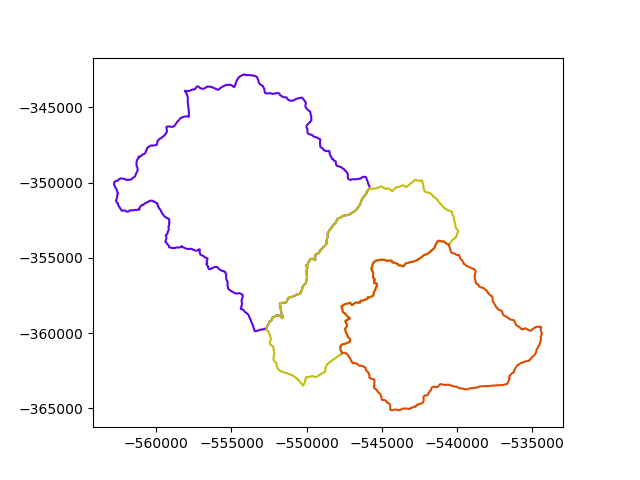

In [9]:
# load the huc
my_hucs = watershed_workflow.getShapesByID(sources['HUC'], hucs, crs, level=huc_level)
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)
watershed.plot()

## the Rivers 

In [10]:
# download/collect the river network within that shape's bounds
reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers

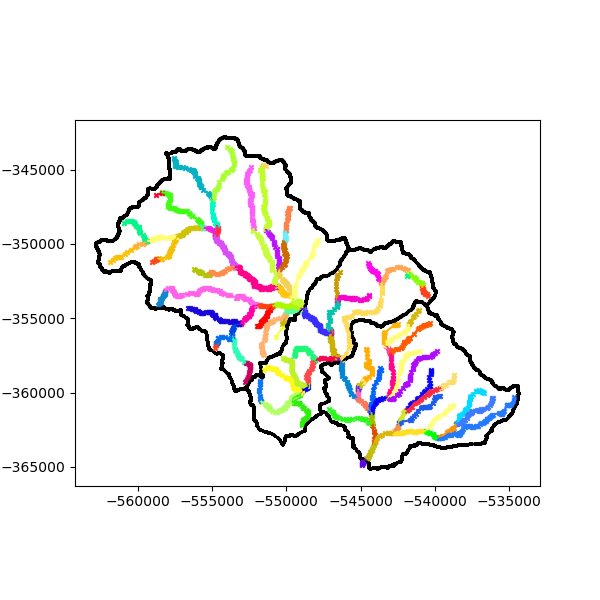

In [11]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)


plot(watershed, rivers)


In [12]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]


In [13]:
   
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# prune
rivers = watershed_workflow.reduceRivers(rivers, 
                                         prune_by_area=prune_by_area_fraction * watershed.exterior.area/1e6,
                                         remove_diversions=True,
                                         remove_braided_divergences=True)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 75, 75, 100, 500)
print(rivers[0].df.crs)

# Now that the river network is set, find the watershed boundary outlets
for river in rivers:
    watershed_workflow.hydrography.findOutletsByCrossings(watershed, river)

2025-08-01 15:51:50,292 - root - INFO: Removing rivers with area < 6.073632854502017
2025-08-01 15:51:50,293 - root - INFO: Removing divergent sections...
2025-08-01 15:51:50,293 - root - INFO:   ... removed 0 divergence tributaries with 0 total reaches.
2025-08-01 15:51:50,323 - root - INFO: ... pruned 53 of 113
2025-08-01 15:51:50,323 - root - INFO: 
2025-08-01 15:51:50,323 - root - INFO: Simplifying
2025-08-01 15:51:50,324 - root - INFO: ------------------------------
2025-08-01 15:51:50,324 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-01 15:51:50,324 - root - INFO: Presimplify to remove colinear, coincident points.
2025-08-01 15:51:50,327 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
2025-08-01 15:51:50,328 - root - INFO: Pruning leaf reaches < 75
2025-08-01 15:51:50,328 - root - INFO: +proj=lcc +lat_1=25 +lat_2=60 +lat

+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs


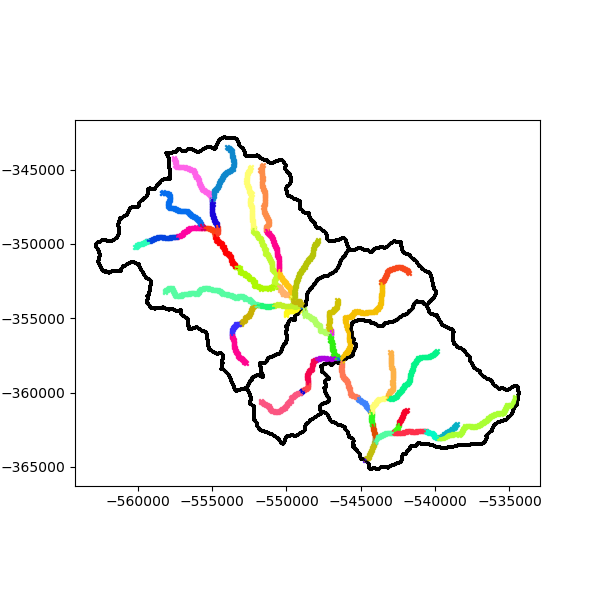

In [14]:
plot(watershed, rivers)

In [15]:
watershed.exterior_outlet = shapely.geometry.Point(rivers[0].linestring.coords[-1])

In [16]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
m = watershed_workflow.makeMap(m)
m

In [17]:
# checkpoint here, saving both rivers and hucs to disk
# note, this is the preferred way to save a list of rivers!
river_df = pandas.concat([river.to_dataframe() for river in rivers])
river_df.to_parquet(name + '_rivers.parquet')
with open(name+'_watersheds.pickle', 'wb') as fid:
    pickle.dump(watershed, fid)
    

## Mesh Geometry

Discretely create the stream-aligned mesh.  Download elevation data, and condition the mesh discretely to make for better topography.

In [18]:
# if loading from checkpoint, skip the previous subsubsection
reaches_df = geopandas.read_parquet(name+'_rivers.parquet')
rivers = watershed_workflow.river_tree.createRivers(reaches_df, method='native')

with open(name+'_watersheds.pickle', 'rb') as fid:
    watershed = pickle.load(fid)

In [19]:
# how many types of Stream Orders are there
set([r[names.ORDER] for r in rivers[0].preOrder()])

{np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

2025-08-01 15:51:52,121 - root - INFO: 
2025-08-01 15:51:52,121 - root - INFO: Stream-aligned Meshing
2025-08-01 15:51:52,122 - root - INFO: ------------------------------
2025-08-01 15:51:52,122 - root - INFO: Creating stream-aligned mesh...
2025-08-01 15:51:52,273 - root - INFO: Adjusting HUC to match reaches at outlet
2025-08-01 15:51:52,278 - root - INFO: Adjusting HUC to match reaches at reach 6 and coordinate (-546348.9429845376, -357841.9509549553)
2025-08-01 15:51:52,282 - root - INFO: Adjusting HUC to match reaches at reach 14 and coordinate (-548915.8617565744, -354311.3539136959)
2025-08-01 15:51:52,299 - root - INFO: Plotting the river mesh


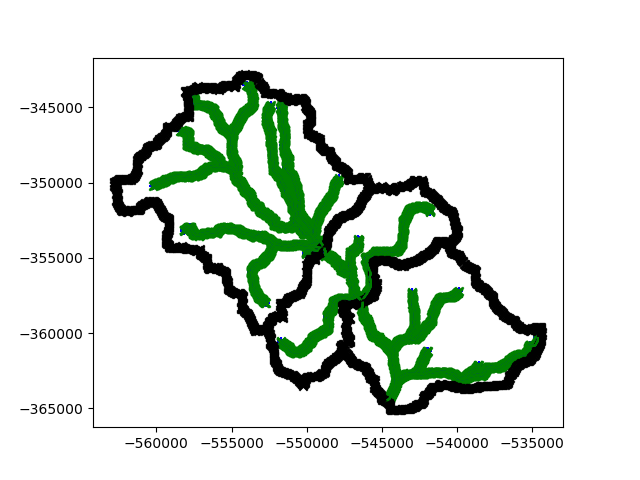

2025-08-01 15:51:55,146 - root - INFO: 
2025-08-01 15:51:55,147 - root - INFO: Triangulation
2025-08-01 15:51:55,147 - root - INFO: ------------------------------
2025-08-01 15:51:55,173 - root - INFO: Triangulating...
2025-08-01 15:51:55,181 - root - INFO:    5220 points and 5225 facets
2025-08-01 15:51:55,181 - root - INFO:  checking graph consistency
2025-08-01 15:51:55,181 - root - INFO:  tolerance is set to 1.0
2025-08-01 15:51:55,196 - root - INFO:  building graph data structures
2025-08-01 15:51:55,211 - root - INFO:  triangle.build...
2025-08-01 15:53:36,749 - root - INFO:   ...built: 13014 mesh points and 21189 triangles
2025-08-01 15:53:36,750 - root - INFO: Plotting triangulation diagnostics
2025-08-01 15:53:37,391 - root - INFO:   min area = 110.769287109375
2025-08-01 15:53:37,391 - root - INFO:   max area = 49989.87419128418


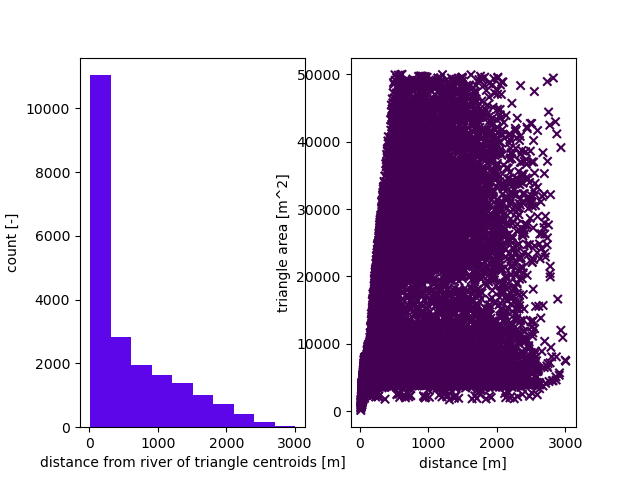

In [20]:
## Triangulation

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
widths = dict({1:10, 2:10, 3:20, 4:30}) 

m2, area, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True, debug=True)

In [21]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# provide surface mesh elevations
watershed_workflow.elevate(m2, dem)

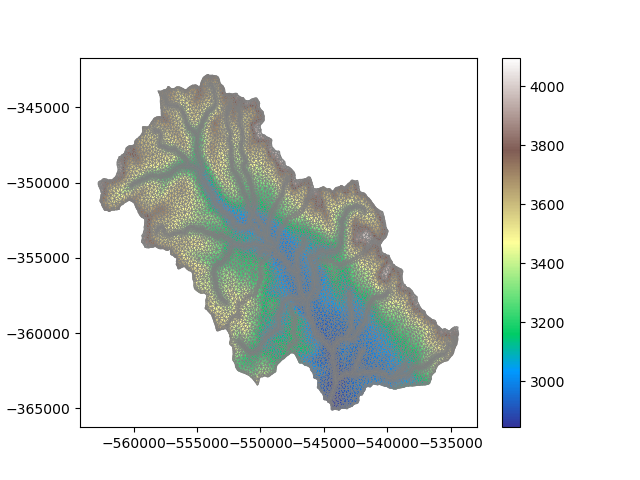

In [22]:
fig, ax = plt.subplots()
m2.plot(facecolors='elevation', ax=ax)
plt.show()

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [23]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [24]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMesh(m2, rivers[0])

2025-08-01 15:53:42,874 - matplotlib.axes._base - WARNING: Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


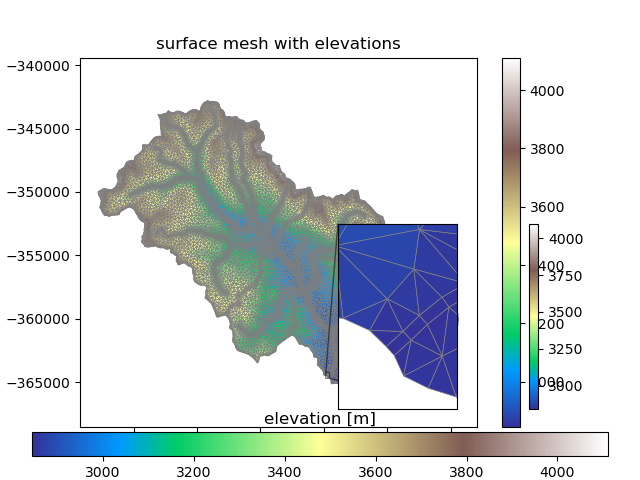

In [25]:
# plotting surface mesh with elevations
fig, ax = plt.subplots()
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

# Get elevation data range
elev_min = m2.coords[:,2].min()
elev_max = m2.coords[:,2].max()

# Create normalized colormap
norm = plt.Normalize(vmin=elev_min, vmax=elev_max)

mp = m2.plot(facecolors='elevation', ax=ax, linewidth=0.5, norm=norm)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = m2.plot(facecolors='elevation', ax=ax2)
ax2.set_aspect('equal', 'datalim')

xlim =(-544850, -544550)
ylim = (-364650, -364250)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [26]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.addWatershedAndOutletRegions(m2, watershed, outlet_width=stream_outlet_width, exterior_outlet=True)

# add labeled sets for river corridor cells
watershed_workflow.regions.addRiverCorridorRegions(m2, rivers)

# add labeled sets for river corridor cells by order
watershed_workflow.regions.addStreamOrderRegions(m2, rivers)

2025-08-01 15:53:43,449 - root - INFO: Adding regions for 3 polygons


Note the regions specific to subcatchments

In [27]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

10000 : CELL : 11611 : "Headwaters Taylor River"
10001 : CELL : 11611 : "Headwaters Taylor River surface"
10002 : CELL : 5134 : "Upper Taylor River"
10003 : CELL : 5134 : "Upper Taylor River surface"
10004 : CELL : 6224 : "Middle Taylor River"
10005 : CELL : 6224 : "Middle Taylor River surface"
10006 : FACE : 825 : "Headwaters Taylor River boundary"
10007 : FACE : 16 : "Headwaters Taylor River outlet"
10008 : FACE : 636 : "Upper Taylor River boundary"
10009 : FACE : 17 : "Upper Taylor River outlet"
10010 : FACE : 599 : "Middle Taylor River boundary"
10011 : FACE : 17 : "Middle Taylor River outlet"
10012 : FACE : 17 : "surface domain outlet"
10013 : CELL : 1780 : "river corridor 0 surface"
10014 : CELL : 187 : "stream order 4"
10015 : CELL : 599 : "stream order 2"
10016 : CELL : 800 : "stream order 1"
10017 : CELL : 194 : "stream order 3"
